<a href="https://colab.research.google.com/github/timothy-wardlow/UofM-FinTech-Project-2/blob/main/lstm_stock_closing_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
!pip install yfinance
import yfinance as yf

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Data fetching function that allows you to quickly grab data for different tickers and starting points
def Get_Data(tickers, start):
    Data = yf.download(tickers = tickers, start = start)
    return Data
df = Get_Data("NVDA", "2020-04-11")
df["Close"] = df["Adj Close"]
df = df.drop(columns="Adj Close")
df = df.drop(columns="Open")
df = df.drop(columns="High")
df = df.drop(columns="Low")
df = df.drop(columns="Volume")
df

[*********************100%***********************]  1 of 1 completed


Close
Date                  
2020-04-13   67.321381
2020-04-14   70.838989
2020-04-15   70.063110
2020-04-16   73.520882
2020-04-17   72.927116
...                ...
2022-04-08  231.190002
2022-04-11  219.169998
2022-04-12  215.039993
2022-04-13  222.029999
2022-04-14  212.580002

[508 rows x 1 columns]

In [4]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [5]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 8

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(df, window_size, feature_column, target_column)

In [6]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7*len(X))

X_train = X[: split]
y_train = y[: split]
X_test = X[split:]
y_test = y[split:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

s = MinMaxScaler()

s.fit(X_train)
X_train = s.transform(X_train)
X_test = s.transform(X_test)

s.fit(y_train)
y_train = s.transform(y_train)
y_test = s.transform(y_test)

In [8]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [10]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()
num_units = 30
dropout_frac = 0.2

# Layer 1
model.add(LSTM(units=num_units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_frac))

# Layer 2
model.add(LSTM(units=num_units, return_sequences=True))
model.add(Dropout(dropout_frac))

# Layer 3
model.add(LSTM(units=num_units))
model.add(Dropout(dropout_frac))

# Output
model.add(Dense(1))

In [11]:
# Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error')

In [12]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 8, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 8, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [13]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=30, verbose=1)

Epoch 1/10
12/12 [==============================] - 7s 14ms/step - loss: 0.1187
Epoch 2/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 3/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0402
Epoch 4/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0175
Epoch 5/10
12/12 [==============================] - 0s 16ms/step - loss: 0.0140
Epoch 6/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0096
Epoch 7/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0079
Epoch 8/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0070
Epoch 9/10
12/12 [==============================] - 0s 15ms/step - loss: 0.0061
Epoch 10/10
12/12 [==============================] - 0s 14ms/step - loss: 0.0061


---

In [14]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.01883268915116787

In [15]:
# Make some predictions
predicted = model.predict(X_test)

In [16]:
# Recover the original prices instead of the scaled version
predicted_prices = s.inverse_transform(predicted)
real_prices = s.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

Real   Predicted
Date                              
2021-09-13  224.714188  232.425598
2021-09-14  221.455154  231.966751
2021-09-15  222.354874  232.131836
2021-09-16  223.344589  232.059143
2021-09-17  222.354874  231.997574

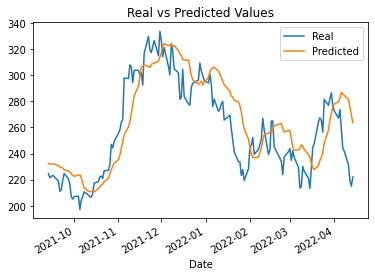

In [18]:
# Plot the real vs predicted values as a line chart
stocks.plot(title="Real vs Predicted Values")

In [21]:
from google.colab import files

stocks.to_csv('stocks.csv', encoding = 'utf-8-sig') 
files.download('stocks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>